<a href="https://colab.research.google.com/github/jchen8000/DemystifyingLLMs/blob/main/4_Pre-Training/En2De_Translation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 4. Pre-Training

**Machine Translation: English to German**

*   4.01 Install and Import Libraries
*   4.02 Global Parameters
*   4.2 Dataset and Tokenization
*   4.3 Load Data in Batch
*   4.4 Pre-Training nn.Transformer Model
*   4.5 Inference
*   4.11 Evaluation


This script is tested and working on Google Colab GPU T4 with below packages

* torch==2.1.0+cu121
* torchvision==0.16.0+cu121
* torchaudio==2.1.0+cu121
* datasets==2.18.0
* spacy==3.7.4
* nltk==3.8.1


## 4.01 Install and Import Libraries

Make sure a folder named "outputs" exist before running.


In [ ]:
!pip install torch torchvision torchaudio  --quiet
!pip install datasets  --quiet
!pip install spacy  --quiet
!pip install nltk --quiet
!python -m spacy download en_core_web_sm  --quiet
!python -m spacy download de_core_news_sm  --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 27.9 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 30.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('de_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab noteb

In [ ]:
import torch
from torch import nn, optim
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset
from datasets import load_dataset
import spacy
import random
import time
import math
import matplotlib.pyplot as plt

## 4.02 Global Parameters

In [ ]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
epochs = 100
torch.manual_seed(8888)
batch_size = 128
learning_rate=1e-3

PAD_IDX = 0
SOS_IDX = 1
EOS_IDX = 2
D_MODEL = 256
NHEAD = 4
NENC_LAYER = 3
NDEC_LAYER = 3
FFN_DIM = 256
DROPOUT = 0.25
MAX_LENGTH = 256
MODEL_PATH = 'outputs/en2de_checkpoint_100epochs.pth'

## 4.2 Dataset and Tokenization

In [ ]:
# Load spacy models for tokenization
spacy_de = spacy.load("de_core_news_sm")
spacy_en = spacy.load("en_core_web_sm")

# Tokenization functions
def tokenize_de(text):
    return [tok.text for tok in spacy_de.tokenizer(text)]

def tokenize_en(text):
    return [tok.text for tok in spacy_en.tokenizer(text)]

# Load the dataset
dataset = load_dataset("bentrevett/multi30k")


In [ ]:
# Build vocabularies
def build_vocab(texts, tokenizer):
    vocabs = []
    max_length = 0
    for text in texts:
        vocabs.extend(tokenizer(text))
        if len(text) > max_length:
          max_length = len(text)
    return sorted(list(set(vocabs))), max_length

# Special tokens
PAD_TOKEN = "<PAD>"  # Padding token
SOS_TOKEN = "<SOS>"  # Start-of-sentence token
EOS_TOKEN = "<EOS>"  # End-of-sentence token
UNK_TOKEN = "<UNK>"  # Unknown token

# Add special tokens to the vocabularies
en_vocab, en_max_len = build_vocab(dataset['train']['en'] + dataset['validation']['en'] + dataset['test']['en'], tokenize_en)
en_vocab = [PAD_TOKEN, SOS_TOKEN, EOS_TOKEN, UNK_TOKEN] + en_vocab

de_vocab, de_max_len = build_vocab(dataset['train']['de'] + dataset['validation']['de'] + dataset['test']['de'], tokenize_de)
de_vocab = [PAD_TOKEN, SOS_TOKEN, EOS_TOKEN, UNK_TOKEN] + de_vocab

SRC_VOCAB_SIZE = len(en_vocab)
TRG_VOCAB_SIZE = len(de_vocab)

print("EN vocab: %d, max_length: %d" % (SRC_VOCAB_SIZE, en_max_len) )
print("DE vocab: %d, max_length: %d" % (TRG_VOCAB_SIZE, de_max_len) )

EN vocab: 11158, max_length: 205
DE vocab: 19953, max_length: 254


In [ ]:
print("Train size:", len(dataset['train']['en']))
print("Validation size:", len(dataset['validation']['en']))
print("Test size:", len(dataset['test']['en']))

Train size: 29000
Validation size: 1014
Test size: 1000


In [ ]:
class VocabTokenizer(nn.Module):
    def __init__(self, vocabulary):
        super().__init__()
        self.vocab_size = len(vocabulary)
        self.idx2word = {index:word for index, word in enumerate(vocabulary)}
        self.word2idx = {word:index for index, word in enumerate(vocabulary)}

    def encode(self, text):
        return [self.word2idx[w] for w in text]

    def decode(self, token):
        return [self.idx2word[i] for i in token]

    def __call__(self, text, encode=True):
        if encode:
            return self.encode(text)
        else:
            return self.decode(text)


vocab_tokenizers = {
    'en': VocabTokenizer(en_vocab),
    'de': VocabTokenizer(de_vocab),
}

## 4.3 Load Data in Batch

In [ ]:
class En2De_Dataset(Dataset):
    def __init__(self, raw_dataset, src_tokenizer, trg_tokenizer, vocab_transforms):
        self.raw_dataset = raw_dataset
        self.src_tokenizer = src_tokenizer
        self.trg_tokenizer = trg_tokenizer
        self.vocab_transforms = vocab_transforms

    def __len__(self):
        return len(self.raw_dataset)

    def __getitem__(self, idx):
        src = self.src_tokenizer(self.raw_dataset[idx]["en"])
        src = self.vocab_transforms["en"](src)
        tgt = self.trg_tokenizer(self.raw_dataset[idx]["de"])
        tgt_in = self.vocab_transforms["de"]([SOS_TOKEN] + tgt)
        tgt_out = self.vocab_transforms["de"](tgt + [EOS_TOKEN])
        return src, tgt_in, tgt_out

def padding(batch):
    src = [torch.tensor(item[0]) for item in batch]
    tgt_in = [torch.tensor(item[1]) for item in batch]
    tgt_out = [torch.tensor(item[2]) for item in batch]
    return  pad_sequence(src, padding_value=0, batch_first=True), \
            pad_sequence(tgt_in, padding_value=0, batch_first=True), \
            pad_sequence(tgt_out, padding_value=0, batch_first=True)

# Create training and validation datasets
train_data = En2De_Dataset(dataset['train'], tokenize_en, tokenize_de, vocab_tokenizers)
val_data = En2De_Dataset(dataset['validation'], tokenize_en, tokenize_de, vocab_tokenizers)
train_loader = DataLoader(train_data, batch_size=batch_size, collate_fn=padding, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, collate_fn=padding, shuffle=False)

## 4.4	Pre-Training nn.Transformer Model

In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000, dropout=DROPOUT):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe_table', pe)

    def forward(self, x):
        x = x + self.pe_table[:, :x.size(1), :]
        return self.dropout(x)

class TransformerModel(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, d_model, nhead, num_encoder_layers, num_decoder_layers, dim_feedforward, dropout=DROPOUT, max_seq_length=MAX_LENGTH):
        super(TransformerModel, self).__init__()

        self.source_embedding = nn.Embedding(src_vocab_size, d_model)
        self.target_embedding = nn.Embedding(tgt_vocab_size, d_model)
        self.positional_encoding = PositionalEncoding(d_model, max_seq_length)

        self.transformer = nn.Transformer(
            d_model=d_model,
            nhead=nhead,
            num_encoder_layers=num_encoder_layers,
            num_decoder_layers=num_decoder_layers,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True,
        )
        self.output_layer = nn.Linear(d_model, tgt_vocab_size)

    def forward(self, src, tgt, src_mask, tgt_mask, src_padding_mask, tgt_padding_mask, memory_padding_mask):
        src_emb = self.positional_encoding(self.source_embedding(src))
        tgt_emb = self.positional_encoding(self.target_embedding(tgt))

        output = self.transformer(
            src_emb, tgt_emb,
            src_mask, tgt_mask,
            src_key_padding_mask=src_padding_mask,
            tgt_key_padding_mask=tgt_padding_mask,
            memory_key_padding_mask=memory_padding_mask)
        return self.output_layer(output)

    def encoder(self, src, src_mask):
        return self.transformer.encoder(self.positional_encoding(self.source_embedding(src)), src_mask)

    def decoder(self, tgt, memory, tgt_mask):
        return self.transformer.decoder(self.positional_encoding(self.target_embedding(tgt)), memory, tgt_mask)

# Instantiate the Transformer model
model = TransformerModel(
    src_vocab_size = SRC_VOCAB_SIZE,
    tgt_vocab_size = TRG_VOCAB_SIZE,
    d_model = D_MODEL,
    nhead = NHEAD,
    num_encoder_layers = NENC_LAYER,
    num_decoder_layers = NDEC_LAYER,
    dim_feedforward = FFN_DIM,
).to(device)

In [ ]:
total_parameter = sum(p.numel() for p in model.parameters())
print(f"Parameters of the model: {total_parameter:,}")

Parameters of the model: 16,259,057


Create masks, loss function, and optimizer

In [ ]:
def create_mask(src, tgt, pad_idx=PAD_IDX):
    src_seq_len = src.shape[1]
    tgt_seq_len = tgt.shape[1]

    src_mask = torch.zeros((src_seq_len, src_seq_len),device=device).type(torch.bool)
    tgt_mask = model.transformer.generate_square_subsequent_mask(tgt_seq_len)

    src_padding_mask = (src == pad_idx)
    tgt_padding_mask = (tgt == pad_idx)
    return src_mask, tgt_mask, src_padding_mask, tgt_padding_mask

criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9, 0.98), eps=1e-9)

Main training loop

In [ ]:
history_loss = []
history_val = []

start_time = time.time()
for epoch in range(epochs):
    model.train()
    train_batches = len(train_loader)
    train_losses = 0
    for i, [src, tgt_in, tgt_out] in enumerate(train_loader):
        src =  src.to(device)
        tgt_in =  tgt_in.to(device)
        tgt_out = tgt_out.to(device)
        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_in)
        tgt_mask = tgt_mask.to(device)

        optimizer.zero_grad()

        logits = model(src, tgt_in, src_mask, tgt_mask,
                       src_padding_mask, tgt_padding_mask, src_padding_mask)
        logits = logits.reshape(-1, logits.size(-1))
        train_loss = criterion(logits, tgt_out.view(-1))
        train_losses += train_loss.item()

        train_loss.backward()
        optimizer.step()

        # if i % 10 == 0:
        #   print('    Epoch %d, Batch: %d/%d' % (epoch+1, i+1, total_batches ), 'loss =', '{:.6f}'.format(loss))

    model.eval()
    val_batches = len(val_loader)
    val_losses = 0
    with torch.no_grad():  # Disable gradient computation
        for i, [val_src, val_tgt_in, val_tgt_out] in enumerate(val_loader):
            val_src = val_src.to(device)
            val_tgt_in = val_tgt_in.to(device)
            val_tgt_out = val_tgt_out.to(device)

            src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(val_src, val_tgt_in)
            tgt_mask = tgt_mask.to(device)
            output = model(val_src, val_tgt_in, src_mask, tgt_mask,
                           src_padding_mask, tgt_padding_mask, src_padding_mask)

            output = output.reshape(-1, output.size(-1))
            val_loss = criterion(output, val_tgt_out.view(-1))
            val_losses += val_loss.item()

    print('Epoch %d' % (epoch+1),
          'Train loss = {:.6f};'.format(train_losses/train_batches),
          'Validation loss = {:.6f}'.format(val_losses / val_batches))
    history_loss.append(train_losses/train_batches)
    history_val.append(val_losses/val_batches)

end_time = time.time()
print(f"Training time: {(end_time-start_time):.8f} seconds")

Epoch 1 Train loss = 4.960130; Validation loss = 4.115324
Epoch 2 Train loss = 3.858024; Validation loss = 3.576563
Epoch 3 Train loss = 3.414506; Validation loss = 3.259989
Epoch 4 Train loss = 3.098718; Validation loss = 3.068064
Epoch 5 Train loss = 2.853402; Validation loss = 2.880256
Epoch 6 Train loss = 2.658215; Validation loss = 2.743590
Epoch 7 Train loss = 2.490830; Validation loss = 2.669578
Epoch 8 Train loss = 2.341820; Validation loss = 2.565256
Epoch 9 Train loss = 2.211867; Validation loss = 2.486574
Epoch 10 Train loss = 2.093264; Validation loss = 2.402130
Epoch 11 Train loss = 1.984778; Validation loss = 2.393718
Epoch 12 Train loss = 1.888311; Validation loss = 2.349503
Epoch 13 Train loss = 1.798413; Validation loss = 2.340495
Epoch 14 Train loss = 1.717178; Validation loss = 2.318586
Epoch 15 Train loss = 1.647081; Validation loss = 2.286606
Epoch 16 Train loss = 1.583832; Validation loss = 2.302268
Epoch 17 Train loss = 1.523039; Validation loss = 2.297541
Epoch 

Visualize training progress

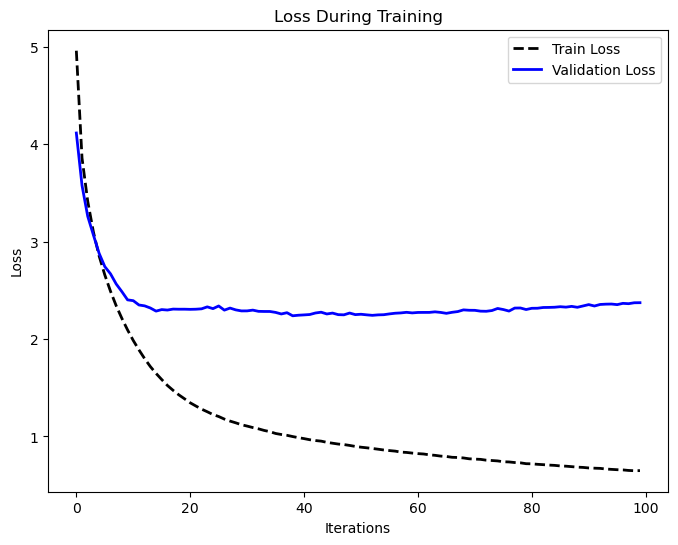

In [ ]:
plt.figure(figsize=(8, 6))
plt.title("Loss During Training")
plt.plot(history_loss, label="Train Loss", c='k', lw=2, ls='--')
plt.plot(history_val, label="Validation Loss", c='b', lw=2)
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.savefig("outputs/en2de_training.svg", format="svg", dpi=150, transparent=True, bbox_inches='tight')
plt.show()


Save the model:

In [ ]:
# Save the model
torch.save(model, MODEL_PATH)

Load the model:

In [ ]:
# Load the model
# model = torch.load(MODEL_PATH)

## 4.5	Inference

In [ ]:
def translate(model, src, max_len=MAX_LENGTH, start_symbol=SOS_IDX, end_symbol=EOS_IDX):
    model.eval()
    src = src.to(device)
    src_mask = torch.zeros((src.shape[1], src.shape[1]),device=device).type(torch.bool).to(device)
    memory = model.encoder(src, src_mask)
    memory = memory.to(device)
    tgt = torch.ones(1, 1).fill_(start_symbol).type(torch.long).to(device)
    for i in range(max_len-1):
        _, tgt_mask, _, _ = create_mask(src, tgt)
        tgt_mask = tgt_mask.to(device)
        out = model.decoder(tgt, memory, tgt_mask)
        prob = model.output_layer(out[:, -1])
        next_word = torch.argmax(prob.squeeze(0), dim=-1, keepdim=False)
        tgt = torch.cat([tgt, torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=1)
        if next_word == end_symbol:
            break
    return tgt

In [ ]:
test_data = En2De_Dataset(dataset['test'], tokenize_en, tokenize_de, vocab_tokenizers)
test_loader = DataLoader(test_data, batch_size=1, collate_fn=padding, shuffle=False)

test_iterator = iter(test_loader)
for i in range(10):
    source, target, _ = next(test_iterator)
    target = target[:, 1:]
    output = translate(model, source)
    print("SOURCE:\t"," ".join(vocab_tokenizers["en"](list(source.view(-1).cpu().numpy()), encode=False)) )
    print("TARGET:\t"," ".join(vocab_tokenizers["de"](list(target.view(-1).cpu().numpy()), encode=False)) )
    print("PREDICT:", " ".join(vocab_tokenizers["de"](list(output.view(-1).cpu().numpy()), encode=False)).replace("<SOS> ", "").replace("<EOS>", "") )
    print("")

SOURCE:	 A man in an orange hat starring at something .
TARGET:	 Ein Mann mit einem orangefarbenen Hut , der etwas anstarrt .
PREDICT: Ein Mann mit orangefarbener Kappe starrt auf etwas . 

SOURCE:	 A Boston Terrier is running on lush green grass in front of a white fence .
TARGET:	 Ein Boston Terrier läuft über saftig-grünes Gras vor einem weißen Zaun .
PREDICT: Ein Fan von grün gekleideten Mann rennt auf dem grüne Gras vor einem weißen Zaun . 

SOURCE:	 A girl in karate uniform breaking a stick with a front kick .
TARGET:	 Ein Mädchen in einem Karateanzug bricht ein Brett mit einem Tritt .
PREDICT: Ein Mädchen in Karateanzügen kämpfen mit einem Stock im Hinterhof . 

SOURCE:	 Five people wearing winter jackets and helmets stand in the snow , with snowmobiles in the background .
TARGET:	 Fünf Leute in Winterjacken und mit Helmen stehen im Schnee mit Schneemobilen im Hintergrund .
PREDICT: Fünf Personen in Winterjacken und mit Helmen stehen im Schnee , im Hintergrund sind schneebedeckt

## 4.11 Evaluation

Using BLEU score to evaluate predictions using the NLTK library in Python.

BLEU (Bilingual Evaluation Understudy), developed by researchers at IBM, is one of the metrics used for evaluating machine translation quality.


In [ ]:
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction

reference_text = "Ein Boston Terrier läuft über saftig-grünes Gras vor einem weißen Zaun."
output_text = "Ein Fan sitzt auf einer grünen Wiese vor einem weißen Zaun"

# Extract tokens
reference = tokenize_de(reference_text)
output = tokenize_de(output_text)

# Calculate BLEU score
score = sentence_bleu([reference], output, smoothing_function=SmoothingFunction().method1)

# Output the BLEU score
print(f"BLEU Score: {score}")

BLEU Score: 0.22652581507881553


In [ ]:
for i in range(10):
    source, target, _ = next(test_iterator)
    target = target[:, 1:]
    output = translate(model, source)
    reference = " ".join(vocab_tokenizers["de"](list(target.view(-1).cpu().numpy()), encode=False))
    output = " ".join(vocab_tokenizers["de"](list(output.view(-1).cpu().numpy()), encode=False)).replace("<SOS> ", "").replace("<EOS>", "")
    reference_tok = tokenize_de(reference)
    output_tok = tokenize_de(output)
    score = sentence_bleu([reference], output, smoothing_function=SmoothingFunction().method1)

    print("SOURCE:\t"," ".join(vocab_tokenizers["en"](list(source.view(-1).cpu().numpy()), encode=False)) )
    print("TARGET:\t", reference)
    print("PREDICT:", output )
    print("BLUE Score:", score)
    print("")

SOURCE:	 People standing outside of a building .
TARGET:	 Leute , die vor einem Gebäude stehen .
PREDICT: Leute stehen vor einem Gebäude . 
BLUE Score: 0.7941535973735969

SOURCE:	 A teenager plays her trumpet on the field at a game .
TARGET:	 Eine Teenagerin spielt bei einem Spiel Trompete auf dem Feld .
PREDICT: Ein Teenager spielt bei einem Spiel auf dem Feld . 
BLUE Score: 0.7373377017701436

SOURCE:	 A woman does a somersault on a trampoline on the beach .
TARGET:	 Eine Frau macht einen Salto auf einem Trampolin am Strand .
PREDICT: Eine Frau macht am Strand einen Salto auf einem Trampolin . 
BLUE Score: 0.9472932821593206

SOURCE:	 A man is standing by a group of video games in a bar .
TARGET:	 Ein Mann steht bei einigen Spielautomaten in einer Bar .
PREDICT: Ein Mann steht bei einer Gruppe von Videospiele in einer Bar . 
BLUE Score: 0.6188389430252332

SOURCE:	 A woman uses a drill while another man takes her picture .
TARGET:	 Eine Frau verwendet eine Bohrmaschine während ein M

## References:


*   https://pytorch.org/tutorials/beginner/translation_transformer.html
*   https://debuggercafe.com/language-translation-using-pytorch-transformer/

